<a href="https://colab.research.google.com/github/Stroded4ever/MQP/blob/main/Proj_multivar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 13.4 MB/s eta 0:00:00


In [4]:
# =====================================================
# Project: Multivariate GARCH Analysis
# =====================================================
# Author: Joshua Angel
# Description:
#   - Estimate GARCH(1,1) volatility for AAPL and MSFT
#   - Compute time-varying correlation (Bivariate GARCH)
#   - Identify negative correlation periods between AAPL and SO
# =====================================================

# =======================
# 1. Library Imports
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from arch import arch_model
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')
np.seterr(all='ignore')

# Configure aesthetics
sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

[*********************100%***********************]  2 of 2 completed

Task 1 – GARCH(1,1) Volatility Estimation

AAPL GARCH(1,1) Results:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1443.11
Distribution:                  Normal   AIC:                           2894.23
Method:            Maximum Likelihood   BIC:                           2912.72
                                        No. Observations:                  752
Date:                Fri, Oct 10 2025   Df Residuals:                      751
Time:                        23:38:33   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------------------------------------------------------

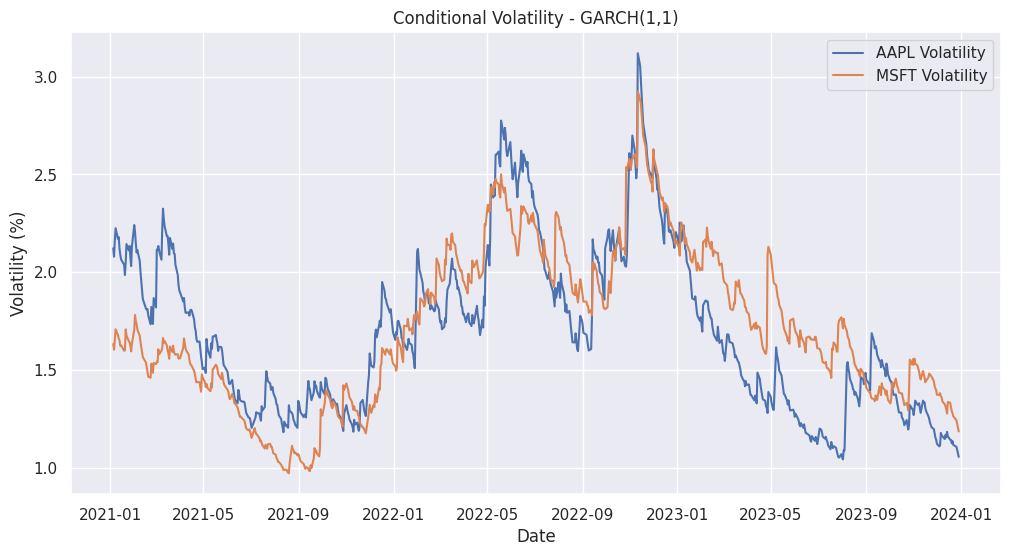

In [8]:
print("=" * 60)
print("Task 1 – GARCH(1,1) Volatility Estimation")
print("=" * 60)

import yfinance as yf
from arch import arch_model

# Download 3-year daily prices for AAPL and MSFT
tickers = ["AAPL", "MSFT"]
data = yf.download(tickers, start="2021-01-01", end="2024-01-01")

# --- FIX: Detect correct adjusted closing price columns robustly ---
if isinstance(data.columns, pd.MultiIndex):
    # Multi-index columns (usual format)
    if 'Adj Close' in data.columns.levels[0]:
        data_close = data['Adj Close']
    elif 'Close' in data.columns.levels[0]:
        data_close = data['Close']
    else:
        raise KeyError(f"No 'Adj Close' or 'Close' columns found in downloaded data. Columns were: {data.columns.levels[0]}")
else:
    # Single-level columns (less common)
    possible_cols = [col for col in ['Adj Close', 'Close'] if col in data.columns]
    if len(possible_cols) == 0:
        raise KeyError(f"No 'Adj Close' or 'Close' column found. Columns were: {list(data.columns)}")
    data_close = data[possible_cols[0]]  # choose the first available

# Handle both single and multiple tickers
if isinstance(data_close, pd.Series):
    data_close = data_close.to_frame()

# Calculate daily returns
returns = data_close.pct_change().dropna()

# Fit GARCH(1,1) models
models = {}
results = {}
for t in tickers:
    model = arch_model(returns[t] * 100, vol='GARCH', p=1, q=1)
    res = model.fit(disp='off')
    models[t] = model
    results[t] = res
    print(f"\n{t} GARCH(1,1) Results:")
    print(res.summary())

# Plot conditional volatilities
plt.figure(figsize=(12,6))
for t in tickers:
    plt.plot(results[t].conditional_volatility, label=f"{t} Volatility")

plt.title("Conditional Volatility - GARCH(1,1)")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.show()

Task 2 – Bivariate GARCH(1,1) Correlation Estimation


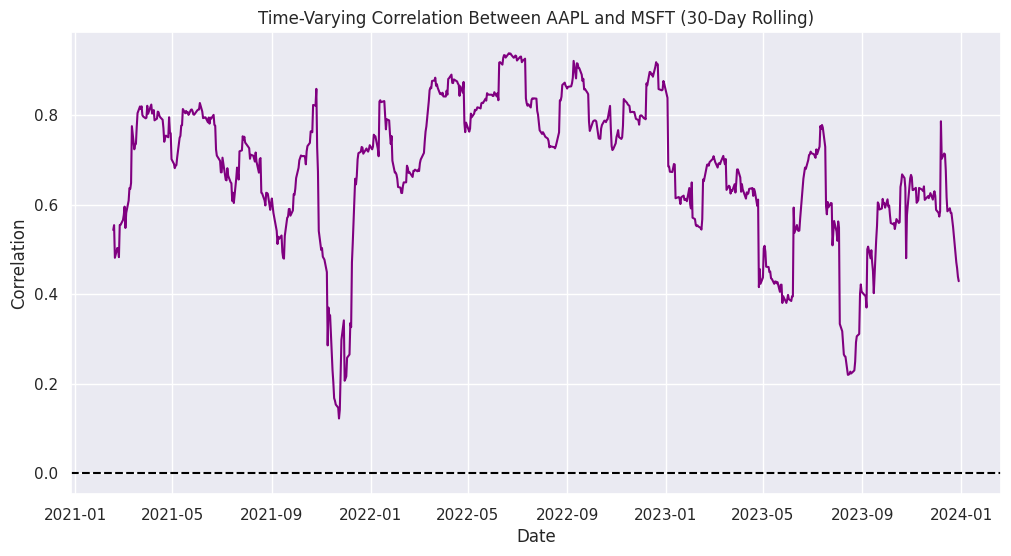

In [9]:
print("=" * 60)
print("Task 2 – Bivariate GARCH(1,1) Correlation Estimation")
print("=" * 60)

# Extract standardized residuals
std_resids = pd.DataFrame({
    'AAPL': results['AAPL'].std_resid,
    'MSFT': results['MSFT'].std_resid
}).dropna()

# Rolling 30-day correlation
window = 30
rolling_corr = std_resids['AAPL'].rolling(window).corr(std_resids['MSFT'])

# Plot correlation dynamics
plt.figure(figsize=(12,6))
plt.plot(rolling_corr, color='purple')
plt.title("Time-Varying Correlation Between AAPL and MSFT (30-Day Rolling)")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.axhline(0, color='black', linestyle='--')
plt.show()

[*********************100%***********************]  2 of 2 completed

Task 3 – Negative Correlation Analysis


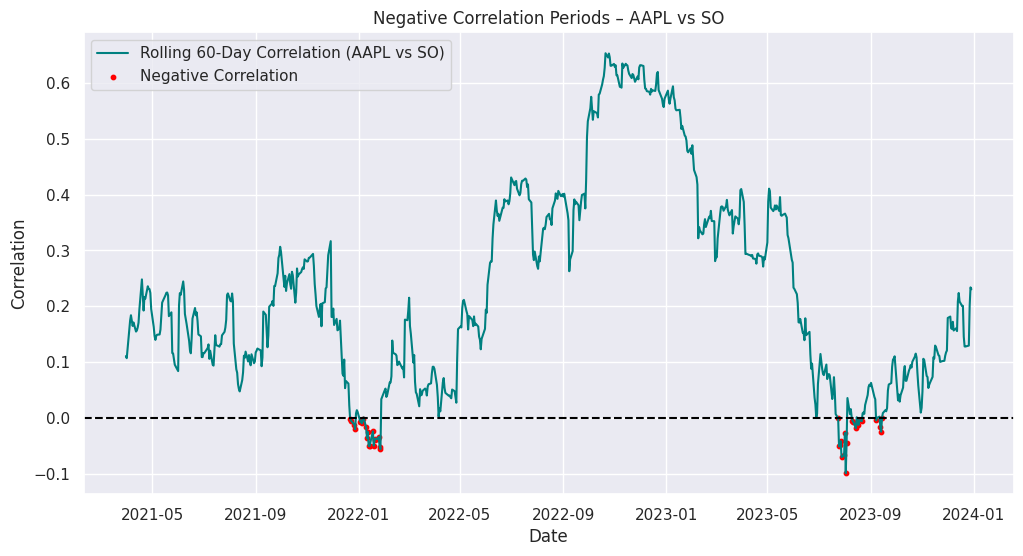

In [11]:
print("=" * 60)
print("Task 3 – Negative Correlation Analysis")
print("=" * 60)

# Download AAPL (Tech) and SO (Utilities)
pair = ["AAPL", "SO"]
pair_data = yf.download(pair, start="2021-01-01", end="2024-01-01")

# --- FIX: handle 'Adj Close' or 'Close' safely ---
if isinstance(pair_data.columns, pd.MultiIndex):
    if 'Adj Close' in pair_data.columns.levels[0]:
        pair_close = pair_data['Adj Close']
    elif 'Close' in pair_data.columns.levels[0]:
        pair_close = pair_data['Close']
    else:
        raise KeyError(
            f"No 'Adj Close' or 'Close' columns found. "
            f"Available columns: {pair_data.columns.levels[0].tolist()}"
        )
else:
    possible_cols = [col for col in ['Adj Close', 'Close'] if col in pair_data.columns]
    if not possible_cols:
        raise KeyError(
            f"No 'Adj Close' or 'Close' column found. "
            f"Available columns: {list(pair_data.columns)}"
        )
    pair_close = pair_data[possible_cols[0]]

# Ensure we have a DataFrame (handles single ticker fallback)
if isinstance(pair_close, pd.Series):
    pair_close = pair_close.to_frame()

# Calculate daily returns
pair_returns = pair_close.pct_change().dropna()

# Compute 60-day rolling correlation
rolling_corr_pair = pair_returns['AAPL'].rolling(60).corr(pair_returns['SO'])

# Identify periods of negative correlation
negative_periods = rolling_corr_pair[rolling_corr_pair < 0]

# Plot results
plt.figure(figsize=(12,6))
plt.plot(rolling_corr_pair, label="Rolling 60-Day Correlation (AAPL vs SO)", color='teal')
plt.axhline(0, color='black', linestyle='--')
plt.scatter(
    negative_periods.index, negative_periods.values,
    color='red', label='Negative Correlation', s=10
)
plt.title("Negative Correlation Periods – AAPL vs SO")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.legend()
plt.show()